# Install packages

In [ ]:
!python -m pip install pyyaml
import sys, os, distutils.core
!pip install torch
# Detectron 2
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install torchvision
!pip install opencv-python


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.0/865.0 MB 95.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 127.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 162.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 137.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 211.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 104.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 148.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 246.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 135.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 159.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/usr/bin/sh: 1: nvcc: not found
torch:  2.7 ; cuda:  cu126
detectron2: 0.6


In [ ]:
# Other packages

# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, random
import pandas as pd

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

import cv2
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data.datasets import convert_to_coco_json
import shutil




# Import images from GitHub

In [ ]:
from getpass import getpass
import subprocess

# Get GitHub token
token = getpass("Enter your GitHub token: ")

# Define repository URL
repo_url = f"https://{token}@github.com/casperbak1/Dataprojekt.git"

# Clone the repository if it doesn't exist (latest version)
subprocess.run(["git", "clone", "--branch", "main", "--depth", "1", repo_url])

repo_path = "Dataprojekt"
if os.path.exists(repo_path):  # Check if the repository already exists
    subprocess.run(["git", "sparse-checkout", "init", "--cone"], cwd=repo_path) # Initialize sparse checkout
    subprocess.run(["git", "sparse-checkout", "set", "Data/Clean Data/Overbite Data"], cwd=repo_path) # Set sparse checkout to only include the "Overbite Data" folder

print("Repository cloned with only the 'Overbite Data' folder.")

Enter your GitHub token:  ········


Repository cloned with only the 'Overbite Data' folder.


# Initialise the training data

In [ ]:
######################## DELETE #############################


from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_name = "Overbite_Data"

# Unregister dataset if already registered
if dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(dataset_name)
    MetadataCatalog.remove(dataset_name)
    print(f"Unregistered dataset: {dataset_name}")

In [ ]:
import pandas as pd
import os
import cv2
from detectron2.structures import BoxMode

ANNOTATIONS_FILE = "Dataprojekt/Data/Clean Data/Overbite Data/Updated_Labels.csv"
annotations_df = pd.read_csv(ANNOTATIONS_FILE)
DATASET_PATH = "Dataprojekt/Data/Clean Data/Overbite Data/Annotated Data Pairs"

PIXEL_PER_MM = 1 / 0.08
TOOTH_BOX_HEIGHT_MM = 7      
TOOTH_BOX_WIDTH_MM = 5
BOX_HEIGHT = int(TOOTH_BOX_HEIGHT_MM * PIXEL_PER_MM)  # 125 px
BOX_WIDTH = int(TOOTH_BOX_WIDTH_MM * PIXEL_PER_MM)    # 62 px

# For left/right split (2/3 left, 1/3 right)
LEFT_RATIO = 3 / 5
RIGHT_RATIO = 2 / 5

def my_dataset_function():
    dataset_dicts = []
    grouped_annotations = annotations_df.groupby("Filename")
    for idx, filename in enumerate(os.listdir(DATASET_PATH)):
        if filename.endswith((".jpg", ".png", ".jpeg")):
            record = {}
            file_path = os.path.join(DATASET_PATH, filename)
            image = cv2.imread(file_path)
            height, width = image.shape[:2]
            record["file_name"] = file_path
            record["image_id"] = idx
            record["height"] = height
            record["width"] = width
            record["annotations"] = []

            if filename in grouped_annotations.groups:
                for _, row in grouped_annotations.get_group(filename).iterrows():
                    x, y = row["X"], row["Y"]
                    left = int(BOX_WIDTH * LEFT_RATIO)
                    right = BOX_WIDTH - left
                    box_x = max(int(x - left), 0)
                    box_y = int(y)  # Top edge of the tooth
                    box_w = min(BOX_WIDTH, width - box_x)
                    box_h = min(BOX_HEIGHT, height - box_y)

                    annotation = {
                        "bbox": [box_x, box_y, box_w, box_h],
                        "bbox_mode": BoxMode.XYWH_ABS,
                        "category_id": 0,
                        "keypoints": [x, y, 2],
                        "num_keypoints": 1
                    }
                    record["annotations"].append(annotation)
            dataset_dicts.append(record)
    return dataset_dicts

DatasetCatalog.register("Overbite_Data", my_dataset_function)
MetadataCatalog.get("Overbite_Data").set(
    thing_classes=["tooth"],
    keypoint_names=["apex"],  # Example keypoint name
    keypoint_flip_map=[]
)

Loaded 1585 images with keypoints.


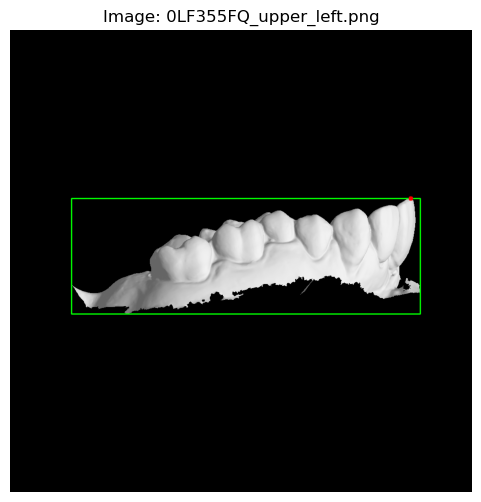

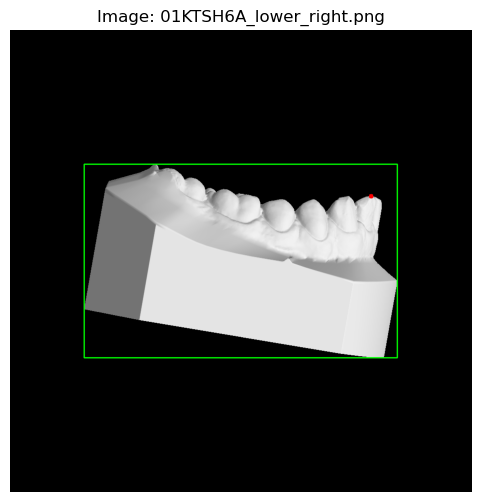

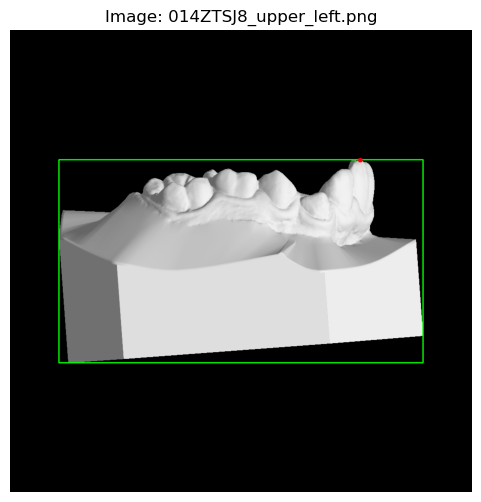

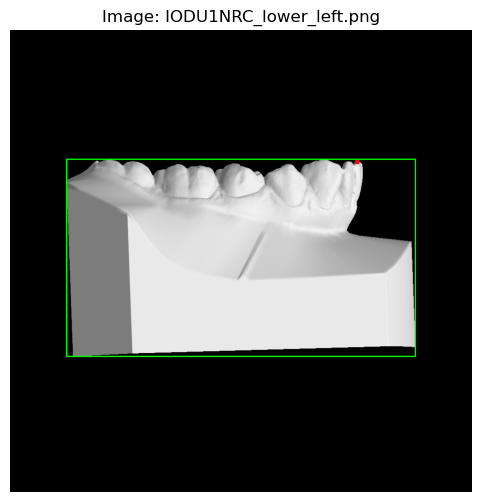

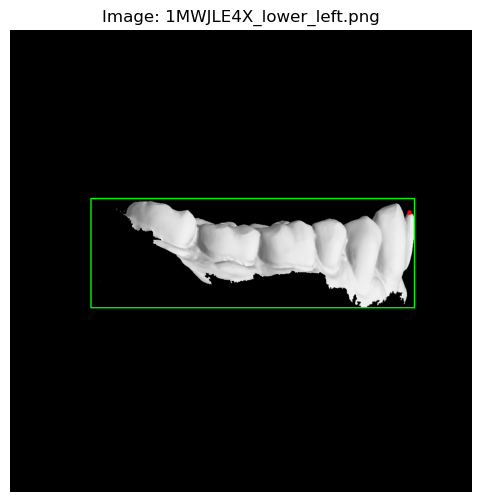

In [ ]:
from detectron2.utils.visualizer import Visualizer
import random
import matplotlib.pyplot as plt

dataset_dicts = DatasetCatalog.get("Overbite_Data")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], MetadataCatalog.get("Overbite_Data"), scale=1.2)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(8,8))
    plt.imshow(out.get_image())
    plt.show()


# Initialise Validation Data

In [ ]:
import pandas as pd
import os
import cv2
from detectron2.structures import BoxMode

# Use the same annotation dataframe and constants
ANNOTATIONS_FILE = "Dataprojekt/Data/Clean Data/Overbite Data/Updated_Labels.csv"
annotations_df = pd.read_csv(ANNOTATIONS_FILE)
VALIDATION_PATH = "Dataprojekt/Data/Clean Data/Overbite Data/Annotated Verication data"

PIXEL_PER_MM = 1 / 0.08
TOOTH_BOX_HEIGHT_MM = 7
TOOTH_BOX_WIDTH_MM = 5
BOX_HEIGHT = int(TOOTH_BOX_HEIGHT_MM * PIXEL_PER_MM)  # 87 px
BOX_WIDTH = int(TOOTH_BOX_WIDTH_MM * PIXEL_PER_MM)    # 62 px

LEFT_RATIO = 3 / 5
RIGHT_RATIO = 2 / 5

def my_validation_function():
    dataset_dicts = []
    grouped_annotations = annotations_df.groupby("Filename")

    for idx, filename in enumerate(os.listdir(VALIDATION_PATH)):
        if filename.endswith((".jpg", ".png", ".jpeg")):
            record = {}
            file_path = os.path.join(VALIDATION_PATH, filename)
            image = cv2.imread(file_path)
            height, width = image.shape[:2]
            record["file_name"] = file_path
            record["image_id"] = idx
            record["height"] = height
            record["width"] = width
            record["annotations"] = []

            if filename in grouped_annotations.groups:
                for _, row in grouped_annotations.get_group(filename).iterrows():
                    x, y = row["X"], row["Y"]
                    left = int(BOX_WIDTH * LEFT_RATIO)
                    right = BOX_WIDTH - left
                    box_x = max(int(x - left), 0)
                    box_y = int(y)
                    box_w = min(BOX_WIDTH, width - box_x)
                    box_h = min(BOX_HEIGHT, height - box_y)
                    annotation = {
                        "bbox": [box_x, box_y, box_w, box_h],
                        "bbox_mode": BoxMode.XYWH_ABS,
                        "category_id": 0,
                        "keypoints": [x, y, 2],
                        "num_keypoints": 1
                    }
                    record["annotations"].append(annotation)
            dataset_dicts.append(record)
    return dataset_dicts

# Register validation dataset
from detectron2.data import DatasetCatalog, MetadataCatalog

DatasetCatalog.register("Overbite_Validation", my_validation_function)
MetadataCatalog.get("Overbite_Validation").set(
    thing_classes=["tooth"],  # keep class name consistent with train
    keypoint_names=["apex"],
    keypoint_flip_map=[]
)

namespace(name='Overbite_Validation',
          thing_classes=['object'],
          keypoint_names=['keypoint'],
          keypoint_flip_map=[])

# Train the model

In [ ]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=r"`torch\.cuda\.amp\.autocast\(args\.\.\.\)` is deprecated.*"
)


import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import build_detection_train_loader
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T

import torch

# --- Custom mapper for keypoint detection with single keypoint ---
def custom_mapper(dataset_dict):
    dataset_dict = dataset_dict.copy()
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    # Good augmentations for medical/dental images:
    aug = [
        T.Resize((800, 800)),
        T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
        T.RandomBrightness(0.9, 1.1),
        T.RandomContrast(0.9, 1.1),
        T.RandomRotation(angle=[-10, 10]),   # NEW: Small random rotation!
    ]

    image, transforms = T.apply_transform_gens(aug, image)
    image_tensor = torch.as_tensor(image.transpose(2, 0, 1).copy(), dtype=torch.float32)
    dataset_dict["image"] = image_tensor

    annos = [
        utils.transform_instance_annotations(
            obj, transforms, image.shape[:2], keypoint_hflip_indices=[0]
        )
        for obj in dataset_dict["annotations"]
    ]
    dataset_dict["instances"] = utils.annotations_to_instances(annos, image.shape[:2])
    return dataset_dict

# --- Custom Trainer ---
class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

# --- Config ---
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x.yaml"
))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x.yaml"
)

cfg.DATASETS.TRAIN = ("Overbite_Data",)
cfg.DATASETS.TEST = ("Overbite_Validation",)
cfg.DATALOADER.NUM_WORKERS = 8

# H100 = can go much higher, but 16 is often enough unless you want massive parallelism
cfg.SOLVER.IMS_PER_BATCH = 64   # Or 64 if GPU memory allows
cfg.SOLVER.BASE_LR = 0.004      # Can go up to 0.005 with more batch

cfg.SOLVER.MAX_ITER = 20000     # Fewer images, so don't overtrain
cfg.SOLVER.STEPS = (12000, 17000)
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.WARMUP_ITERS = 500   # Warmup not strictly needed, but safe
cfg.SOLVER.WARMUP_METHOD = "linear"
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 500

cfg.SOLVER.AMP.ENABLED = True   # H100 will love AMP/mixed precision

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64   # Lower, because only 1 object per image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1             # Only one class
cfg.MODEL.KEYPOINT_ON = True
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 1   # Just one keypoint!

cfg.TEST.KEYPOINT_OKS_SIGMAS = [0.1]            # OKS threshold for eval
cfg.TEST.EVAL_PERIOD = 1000

cfg.OUTPUT_DIR = "./output/Overbite_Model"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# --- Train ---
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()